In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import numpy as np
from scipy.integrate import cumtrapz
from scipy import stats


   Time   Temp   DSC
0   0.0  27.13  0.48
1   1.0  27.13  0.48
2   2.0  27.13  0.48
3   3.0  27.12  0.48
4   4.0  27.13  0.48


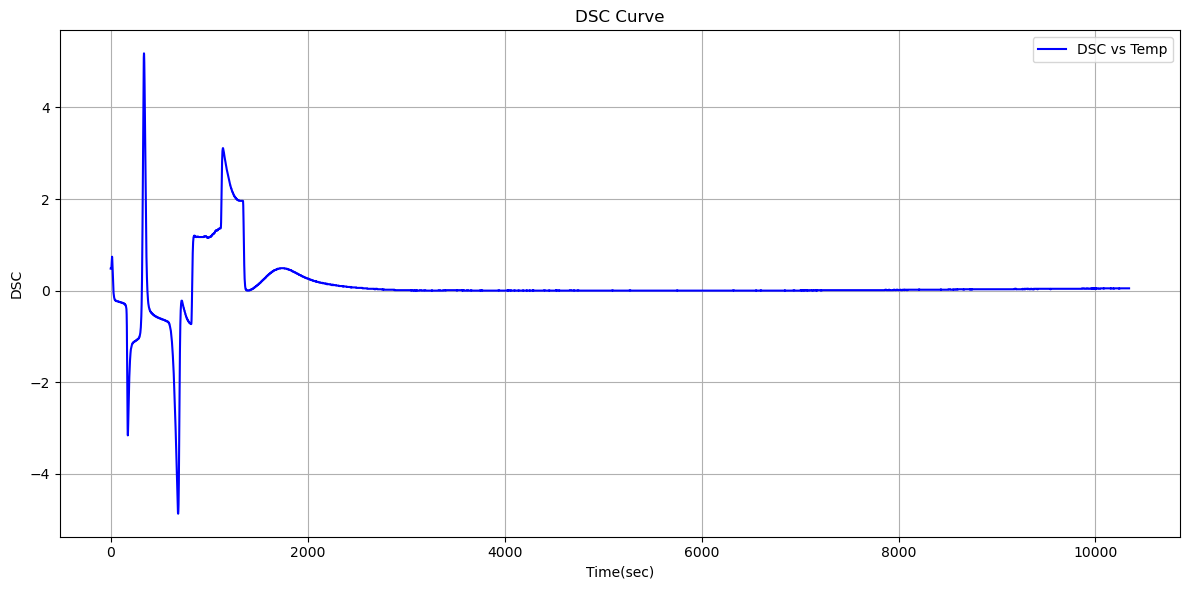

In [3]:
# CSVファイルの読み込み（ファイル名は後で変更）
df = pd.read_csv('PET2.csv')

# データの確認
print(df.head())

# プロット
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['DSC'], label='DSC vs Temp', color='blue')
plt.xlabel('Time(sec)')
plt.ylabel('DSC')
plt.title('DSC Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Timeが1404~積分
平らなところで平均を取る

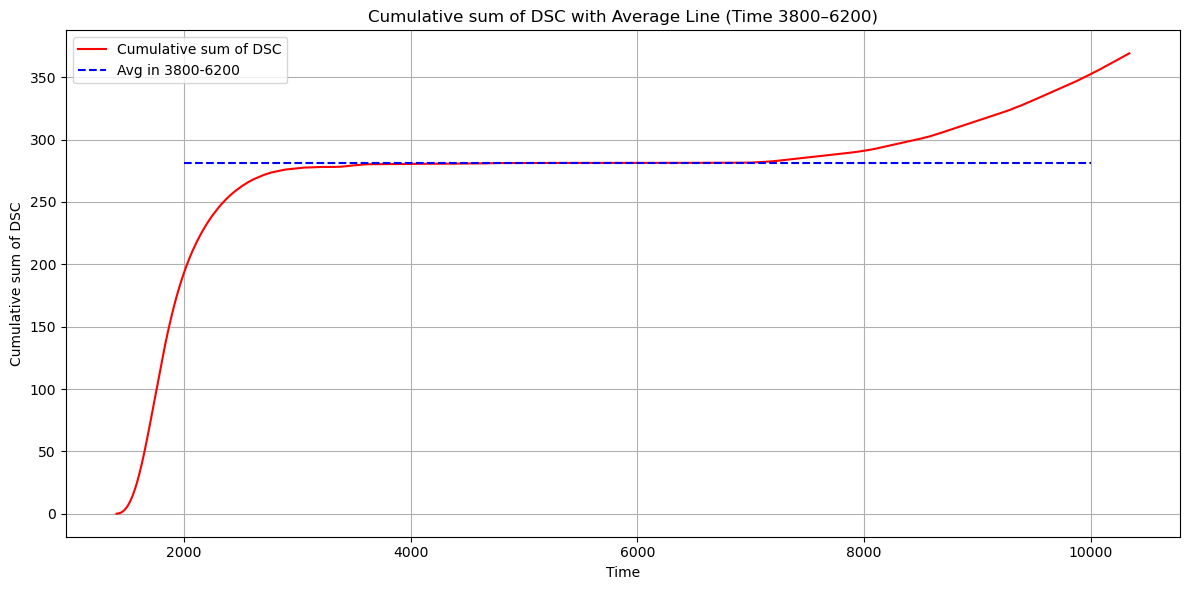

In [19]:
import matplotlib.pyplot as plt

# 元の累積プロットと同じ処理
df_in_range = df[(df['Time'] >= 1404)].reset_index(drop=True)
df_in_range['DSC_cumsum'] = df_in_range['DSC'].cumsum()

# 平均を取る範囲を設定
start_time = 3800
end_time = 6200

# 平均を取るためのフィルタリング
df_avg_range = df_in_range[(df_in_range['Time'] >= start_time) & (df_in_range['Time'] <= end_time)]
dsc_avg = df_avg_range['DSC_cumsum'].mean()

# プロット
plt.figure(figsize=(12,6))
plt.plot(df_in_range['Time'], df_in_range['DSC_cumsum'], color='red', label='Cumulative sum of DSC')

# 平均値を水平線で描く
plt.hlines(y=dsc_avg, xmin=2000, xmax=10000, colors='blue', linestyles='--', label=f'Avg in {start_time}-{end_time}')

plt.xlabel('Time')
plt.ylabel('Cumulative sum of DSC')
plt.title('Cumulative sum of DSC with Average Line (Time 3800–6200)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


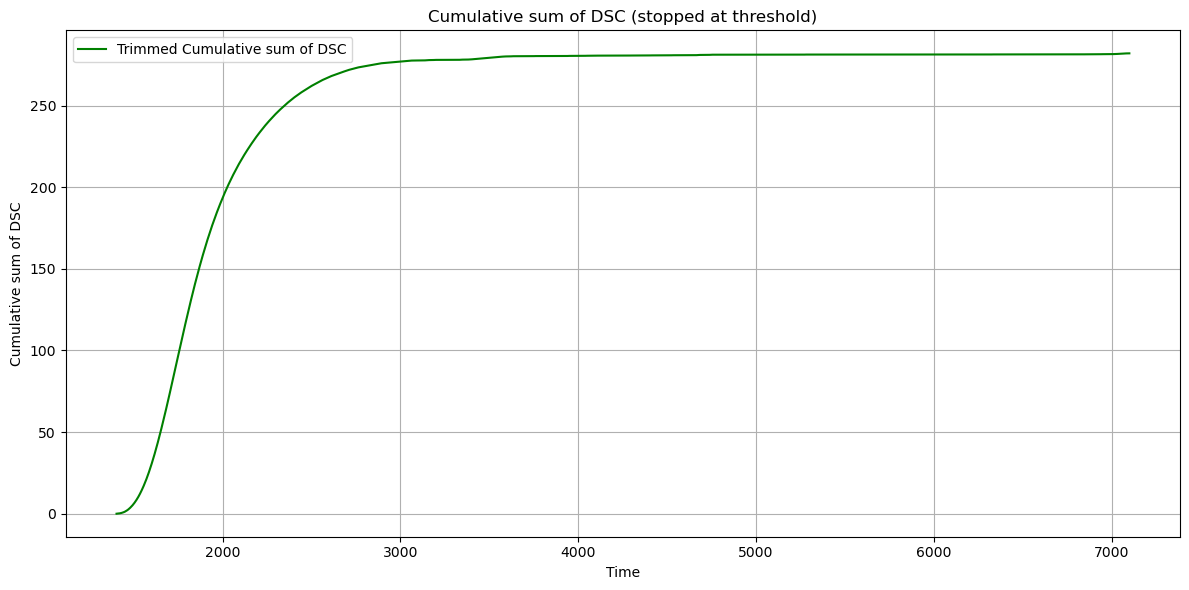

In [5]:
# 閾値の設定

threshold = dsc_avg+1

# 閾値を超えた最初のインデックスを取得
over_index = df_in_range[df_in_range['DSC_cumsum'] > threshold].index.min()

# 該当インデックス以降を削除
if pd.notna(over_index):  # 閾値を超えるデータがあった場合のみ
    df_trimmed = df_in_range.iloc[:over_index].copy()
else:
    df_trimmed = df_in_range.copy()  # 閾値を超えなかった場合は全体を使う
# プロット
plt.figure(figsize=(12,6))
plt.plot(df_trimmed['Time'], df_trimmed['DSC_cumsum'], color='green', label='Trimmed Cumulative sum of DSC')

plt.xlabel('Time')
plt.ylabel('Cumulative sum of DSC')
plt.title('Cumulative sum of DSC (stopped at threshold)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


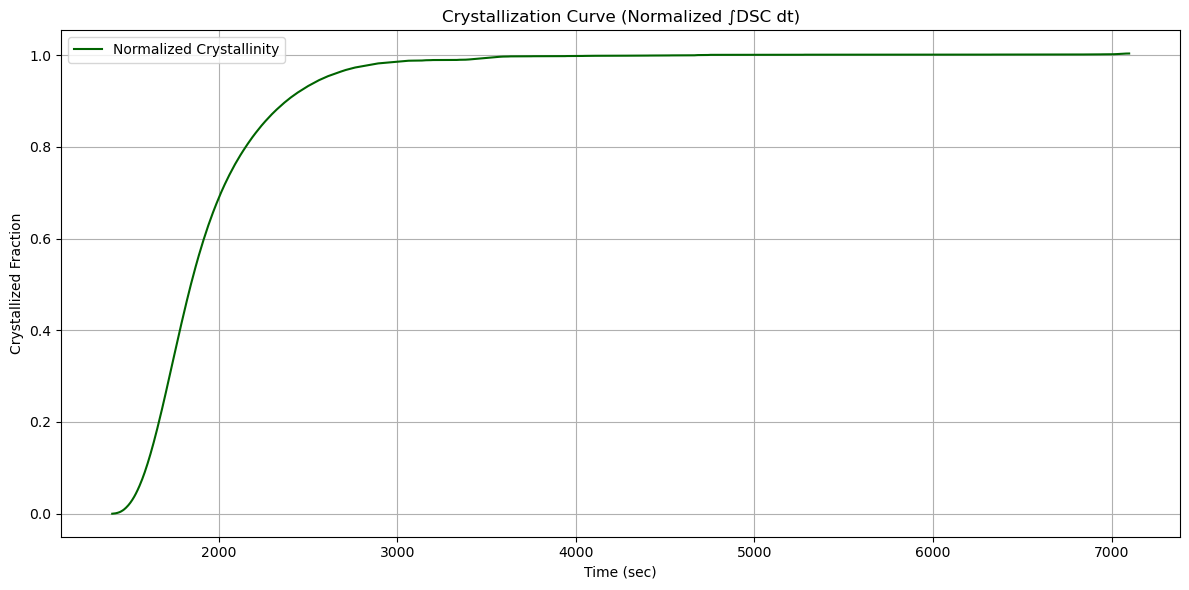

In [6]:



# 最大値で規格化（0〜1）
normalized_crystallinity = df_trimmed['DSC_cumsum'] / dsc_avg

# プロット：結晶化曲線（Time vs Normalized Cumulative DSC）
plt.figure(figsize=(12, 6))
plt.plot(df_trimmed['Time'], normalized_crystallinity, color='darkgreen', label='Normalized Crystallinity')
plt.xlabel('Time (sec)')
plt.ylabel('Crystallized Fraction')
plt.title('Crystallization Curve (Normalized ∫DSC dt)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


[Region 1] ln(t) ∈ [0.00, 2.60]:
  n = 1.0001 ± 0.0000
  k = (3.558e-05 ± 2.173e-10)
  R² = 1.0000
[Region 2] ln(t) ∈ [2.60, 6.00]:
  n = 2.2195 ± 0.0051
  k = (9.364e-07 ± 3.668e-09)
  R² = 0.9979
[Region 3] ln(t) ∈ [6.00, 7.40]:
  n = 1.3913 ± 0.0023
  k = (1.571e-04 ± 1.382e-07)
  R² = 0.9967


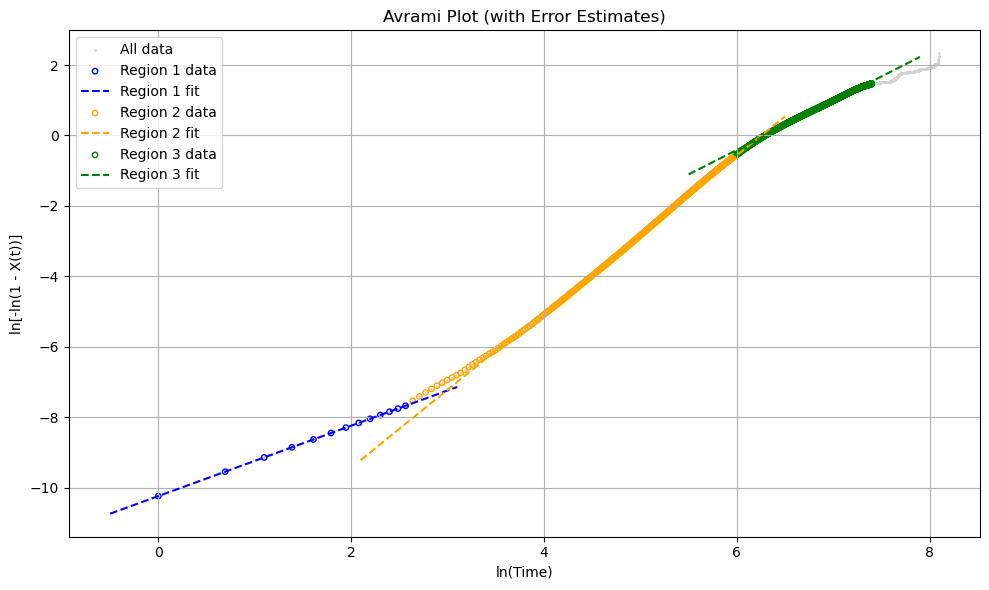

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ゼロ点補正済み Time & Crystallinity
t = df_trimmed['Time'] - df_trimmed['Time'].iloc[0]
X = normalized_crystallinity

# Avrami変換
valid = (X > 0) & (X < 1)
t_valid = t[valid].reset_index(drop=True)
X_valid = X[valid].reset_index(drop=True)

Xlog = np.log(t_valid)
Y = np.log(-np.log(1 - X_valid))

# ln(Time)の範囲を指定
log_range_edges = [Xlog.min(), 2.6, 6.0, 7.4]
colors = ['blue', 'orange', 'green']
labels = ['Region 1', 'Region 2', 'Region 3']

plt.figure(figsize=(10,6))
plt.scatter(Xlog, Y, color='lightgray', label='All data', s=1)

for i in range(3):
    x_start, x_end = log_range_edges[i], log_range_edges[i + 1]
    mask = (Xlog >= x_start) & (Xlog < x_end)
    
    Xlog_i = Xlog[mask]
    Y_i = Y[mask]
    
    if len(Xlog_i) < 2:
        print(f"[{labels[i]}] データ点が不足しているためスキップ")
        continue

    # 線形回帰（標準誤差も出力）
    slope, intercept, r, p, stderr_slope = linregress(Xlog_i, Y_i)
    
    # k の誤差は指数関数のためデルタ法近似で計算
    stderr_intercept = np.std(Y_i - (slope * Xlog_i + intercept)) / np.sqrt(len(Xlog_i))
    k = np.exp(intercept)
    stderr_k = k * stderr_intercept  # ∂/∂b exp(b) = exp(b)

    print(f"[{labels[i]}] ln(t) ∈ [{x_start:.2f}, {x_end:.2f}]:")
    print(f"  n = {slope:.4f} ± {stderr_slope:.4f}")
    print(f"  k = ({k:.3e} ± {stderr_k:.3e})")
    print(f"  R² = {r**2:.4f}")
    
    plt.scatter(Xlog_i, Y_i, facecolors='none', edgecolors=colors[i], label=f'{labels[i]} data', marker='o', s=15)
    x_fit = np.linspace(x_start-0.5, x_end+0.5, 100)
    y_fit = intercept + slope * x_fit
    plt.plot(x_fit, y_fit, color=colors[i], linestyle='--', label=f'{labels[i]} fit')

plt.xlabel('ln(Time)')
plt.ylabel('ln[-ln(1 - X(t))]')
plt.title('Avrami Plot (with Error Estimates)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
df_trimmed.to_csv('df_trimmed_output.csv', index=False)
